# Algorithm Development for Field Boundary Delineation

In [1]:
import descarteslabs as dl
import descarteslabs.workflows as wf
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import gaussian, sobel, threshold_local
from skimage.feature import canny
from skimage.segmentation import watershed, random_walker
from skimage.exposure import equalize_adapthist, rescale_intensity
from skimage.morphology import remove_small_objects

from scipy import ndimage as ndi
from scipy.stats import zscore

/opt/conda/lib/python3.7/site-packages/descarteslabs/common/workflows/arrow_serialization/context.py:57: FutureWarning: 'pyarrow.SerializationContext' is deprecated and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  serialization_context = pa.SerializationContext()
/opt/conda/lib/python3.7/site-packages/descarteslabs/common/workflows/arrow_serialization/context.py:58: FutureWarning: 'pyarrow.register_default_serialization_handlers' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  pa.register_default_serialization_handlers(serialization_context)


## Acessing our published S2 workflow

In [2]:
my_email = "penny.barnes@descarteslabs.com"
version = "1.0.0"
s2_monthly = wf.use(f"{my_email}:sentinel_2_monthly_cloudfree_rgb", version)

Let's pull the data associated with this workflow over a pre-defined AOI. We will be using a DLTile for this. A DLTile is part of the tiling system we use at DL to split up imagery over the whole earth. We can specify parameters like the number of pixels in the x and y axis, resolution, and a pad around the tile.

In [3]:
# lat, lon = 41.949161, -94.424215
lat, lon = 45.053594, -85.642160
resolution = 10
tilesize = 1024
pad = 0
scenes_dltile = dl.scenes.DLTile.from_latlon(lat, lon, resolution, tilesize, pad)

In [4]:
ctx = wf.GeoContext.from_scenes(scenes_dltile)

We'll be grabbing four bands from the Sentinel-2 imagery: red, green, blue, and nir. The nir band is especially useful for distinguishing agricultural fields from other surroundsing objects.

In [5]:
arr = s2_monthly.pick_bands("red green blue nir").compute(ctx).ndarray


Job ID: 7540f3da00bd720abdb399f89472ea7b41535be6b24ddf78
[######] | Steps: 5/5 | Stage: SUCCEEDED                                      

/opt/conda/lib/python3.7/site-packages/descarteslabs/workflows/models/job.py:368: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  return handler(self)


We'll reorder the bands on our image array to better align with what the `skimage` package epects.

In [6]:
arr = np.moveaxis(arr, 1, -1)

In [7]:
ndvi = (arr[:,:,:,-1] - arr[:,:,:,0])/(arr[:,:,:,-1] + arr[:,:,:,0])
ndvi = np.where(ndvi<0, 0, ndvi)

In [8]:
arr = np.append(arr, ndvi[:,:,:,np.newaxis], axis=-1)

We will also set any values in our imagery >1 to 1 to make it compatible with an image processing step later on.

In [9]:
arr = np.where(arr > 1, 1, arr)

## Canny edge detection

Now that we have our features we can proceed with edge detection. For each timeslice and feature we will first be boosting the "contrast" by equalizing the histogram of the image. This is done using `equalize_adapthist()`. Once we've boosted contrast we can then run the Canny edge detection using `canny()`. We specify a `sigma` value for the canny algorithm. This `sigma` corresponds to the standard deviation of the Gaussian filter used to smooth the image in the first step of the algorithm. We select `sigma=3` initially to help smooth out any spurious edges. This is important to avoid over-segmentation later on.

In [10]:
canny_edges = np.zeros_like(arr) # Array to fill with edge detections

for i in range(arr.shape[0]): # Iterate over images
    for j in range(arr.shape[-1]): # Iterate over bands
        # We equalize each 1024x1024 greyscale array for better contrast
        arr_eq = equalize_adapthist(arr[i,:,:,j])
        
        # Now we running the Canny edge detection algorithm over the equalize array
        c_arr = canny(arr_eq, sigma=3)
        
        # Finally we store the edges
        canny_edges[i,:,:,j] = c_arr

Let's take a look at the edges generated for each feature for each monthly composite.

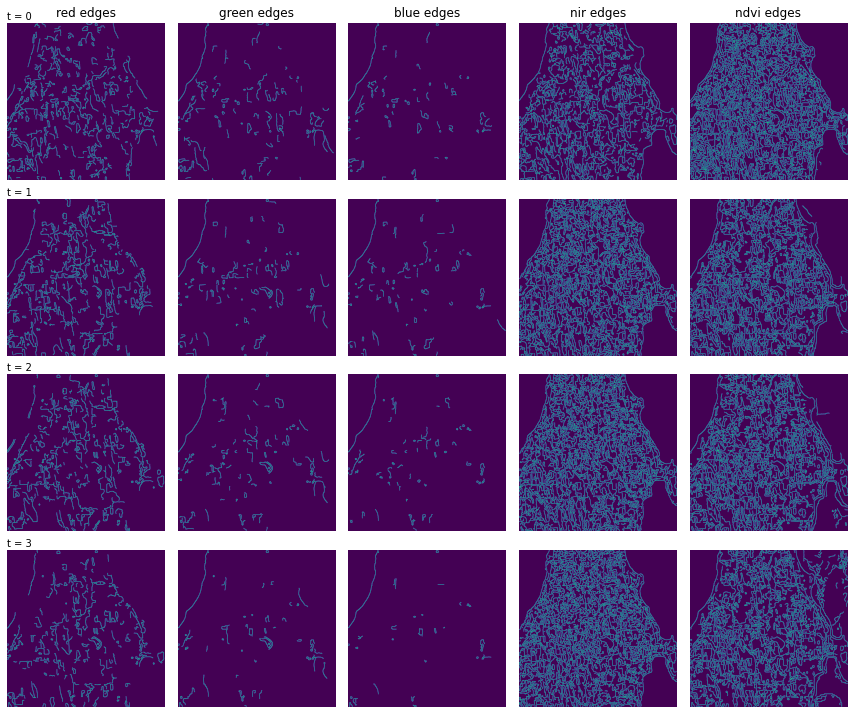

In [11]:
fig, axs = plt.subplots(4, 5, figsize=(12,10))

n_timesteps = 4
n_features = 5
feat_names = ["red", "green", "blue", "nir", "ndvi"]

for i in range(n_timesteps):
    for j in range(n_features):
        axs[i,j].imshow(canny_edges[i, :, :, j], vmax=0.5)
        axs[i,j].axis("off")
        if i == 0:
            axs[i,j].set_title(feat_names[j] + " edges")
        if j ==0:
            axs[i,j].text(0,-20,f"t = {i}")
    
fig.tight_layout()

From the plot above we can see that the edges vary over time and feature by feature. We can leverage this fact to improve our field delineation if we combine the edges over time and over features. We will start by combining over the time dimension by using a mean. Then, to standarized the edges over each feature, we will take the zscore over the bands and rescale that zcore between 0 and 1.

In [12]:
canny_edges_composite = canny_edges.mean(axis=0)

In [13]:
canny_edges_zscore = zscore(canny_edges_composite, axis=-1)
canny_edges_scaled = rescale_intensity(canny_edges_composite, out_range=(0., 1.))

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


We can visualize this standardized mean edge dataset below.

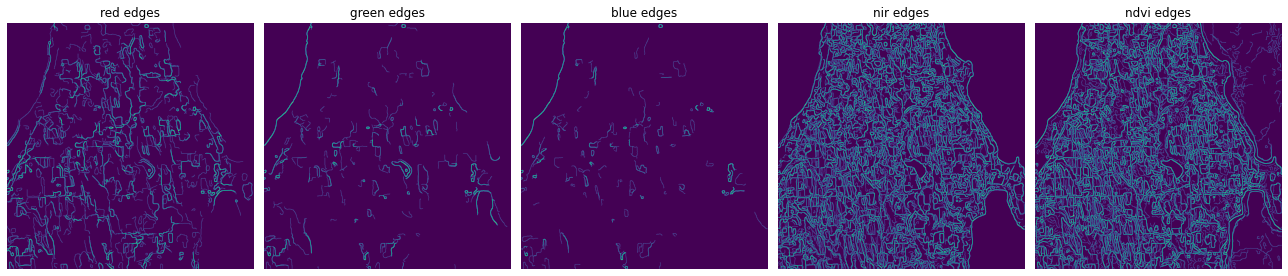

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(18, 6))
axs = axs.flatten()

n_features = 5
feat_names = ["red", "green", "blue", "nir", "ndvi"]


for j in range(n_features):
    axs[j].imshow(canny_edges_scaled[:, :, j], vmax=0.5)
    axs[j].axis("off")
    axs[j].set_title(feat_names[j] + " edges")
    
fig.tight_layout()

-------------

In [15]:


s1_arr = s1.compute(ctx).ndarray
s1_arr = np.moveaxis(s1_arr, 1, -1)

s1_canny_edges = np.zeros_like(s1_arr)  # Array to fill with edge detections

for i in range(s1_arr.shape[0]):  # Iterate over images
    for j in range(s1_arr.shape[-1]):  # Iterate over bands
        # We equalize each 1024x1024 greyscale array for better contrast
        s1_arr_eq = equalize_adapthist(s1_arr[i, :, :, j])
        # Now we running the Canny edge detection algorithm over the equalize array
        s1_c_arr = canny(s1_arr_eq, sigma=5)
        # Finally we store the edges
        s1_canny_edges[i, :, :, j] = s1_c_arr

fig, axs = plt.subplots(5, 2, figsize=(8, 18))

n_timesteps = s1_arr.shape[0]
n_features = s1_arr.shape[-1]
feat_names = ["vv", "vh"]

for i in range(n_timesteps):
    for j in range(n_features):
        axs[i, j].imshow(s1_canny_edges[i, :, :, j], vmax=0.5)
        axs[i, j].axis("off")
        if i == 0:
            axs[i, j].set_title(feat_names[j] + " edges")
        if j == 0:
            axs[i, j].text(0, -20, f"t = {i}")

fig.tight_layout()

NameError: name 's1' is not defined

In [16]:
s1 = wf.ImageCollection.from_id(
    "sentinel-1:GRD",
    start_datetime="2020-07-01",
    end_datetime="2020-09-01",
)

s1 = s1.filter(lambda img: img.properties["pass"] == "ASCENDING")

In [17]:
s1_arr = s1.compute(ctx).ndarray


Job ID: 57b9c1fd4da9b95d388e5b7347982fffd7103f25c2023d6b
[######] | Steps: 64/64 | Stage: SUCCEEDED                                    

In [18]:
canny_edges_merged = canny_edges_scaled.max(axis=-1)

(-0.5, 1023.5, 1023.5, -0.5)

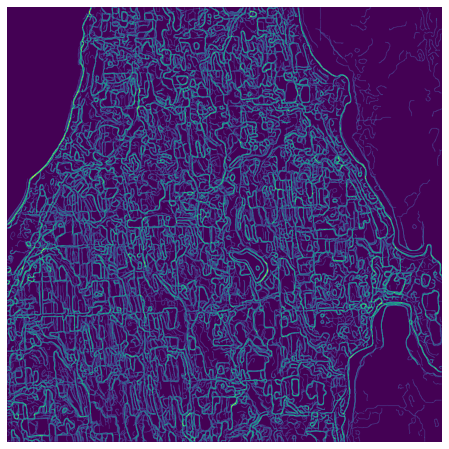

In [19]:
plt.figure(figsize=(8,8))
plt.imshow(canny_edges_merged)
plt.axis("off")

## Watershed segmentation of edge image

Now that we have our generalized edge image we can move on to our watershed algorithm to fill in the edges and get discrete field objects. The watershed algorithm treats our edge (or gradient) image like a topographic map and floods the "basins" (or local minima) to get segments (or in our case fields). The watershed algorithm can use a set of markers that tells the algorithm where to start filling them. We need to specify markers for this application to avoid over-segmentation.

We'll start by passing a Gaussian filter over our generalized edge image to remove some of the spurious low intensity edges. Then we will create a local threshold image that uses a Gaussian kernel of 15x15 pixels that we can then use to threshold our generalized edge image.

In [20]:
canny_edges_merged = gaussian(canny_edges_merged, sigma=3)

In [21]:
canny_edges_merged_thresh = threshold_local(canny_edges_merged, 15)

With the Gaussian filtered edges and local threshold we can now generate the markers for our watershed segmentation. We start by thresholding the generalized edge image by the local threshold. Then we remove small objects (in this case any object that is < 500 pixels in size.

In [22]:
markers = canny_edges_merged < canny_edges_merged_thresh
markers = remove_small_objects(markers, min_size=500, connectivity=4)

We then want to bound the AOI we are looking at with an artificial edge to ensure we capture any fields at the boundary of the AOI.

In [23]:
markers[0, :] = False
markers[:, 0] = False
markers[-1, :] = False
markers[:, -1] = False

Finally we give each marker a unique label and then visualize the result.

In [24]:
markers = ndi.label(markers)[0]

(-0.5, 1023.5, 1023.5, -0.5)

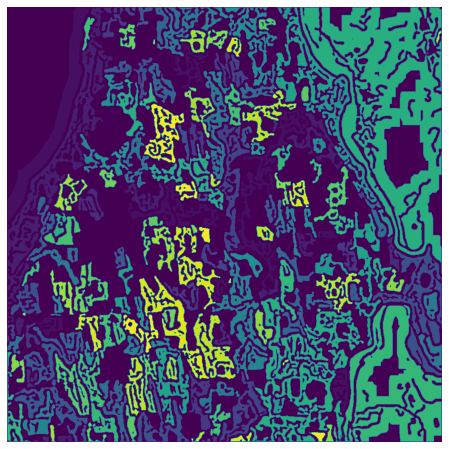

In [25]:
plt.figure(figsize=(8,8))
plt.imshow(markers%25) # We use % 25 here to randomize the marker labels for clearer visualization
plt.axis("off")

------

In [ ]:
# Plot a histogram
plt.hist(canny_edges_merged.flatten())
plt.show()

In [ ]:
# Generate & Display new markers
alt_thresh = 0.1

alt_markers = canny_edges_merged < alt_thresh
alt_markers = remove_small_objects(alt_markers, min_size=500, connectivity=4)

alt_markers[0, :] = False
alt_markers[:, 0] = False
alt_markers[-1, :] = False
alt_markers[:, -1] = False

alt_markers = ndi.label(alt_markers)[0]

plt.figure(figsize=(8, 8))
plt.imshow(alt_markers % 25)
plt.axis("off")

----

We will now run the actual watershed algorithm using `watershed()`. We specify the "heigh map" (our generalized edge image) as the first argument and then our markers as the second.

In [ ]:
labels = watershed(canny_edges_merged, markers)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(labels%25, cmap="tab20c")
plt.axis("off")

For a final step we can choose to filter out any segments we don't believe are agricultural. To do this we will use a simple NDVI threshold. For each segment we can aggregate the NDVI over that segment then compare to our threshold. In this example if the aggreagted NDVI is higher than our threshold then we keep the segment, otherwise we set the segment equal to 0 to remove it from our field map.

In [ ]:
# We compute a max NDVI composite over all months in our ndvi array
max_ndvi = ndvi.max(axis=0)

# We set our threshold at 0.7. We could adjust this depending on our application
ndvi_threshold = 0.7

In [ ]:
# We initialize an empty array for our final agricultural field boundary labels
ag_labels = np.zeros_like(labels)

# We then iterate over each unique segment
for idx in np.unique(labels):
    # We compute the aggregated (in this case mean) NDVi over the field
    agg_ndvi = max_ndvi[labels==idx].mean()
    
    # Then we either keep or discard the segment based on our threshold
    if agg_ndvi > ndvi_threshold:
        ag_labels[labels==idx]=idx

We can take a look at the final NDVI thresholded "agricultural" fields below.

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(np.ma.MaskedArray(ag_labels, mask=ag_labels==0)%25, cmap="tab20c")
plt.axis("off")